### _Imports_

In [155]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pylab as plt

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [156]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

### Outliers

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [157]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [158]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

Now lets see the outliers in scatter plot

In [159]:
cat_var_lst = ["city", "cut", "color", "clarity"]
num_var_lst = ([i for i in list(diamonds_train.columns) if i not in cat_var_lst])

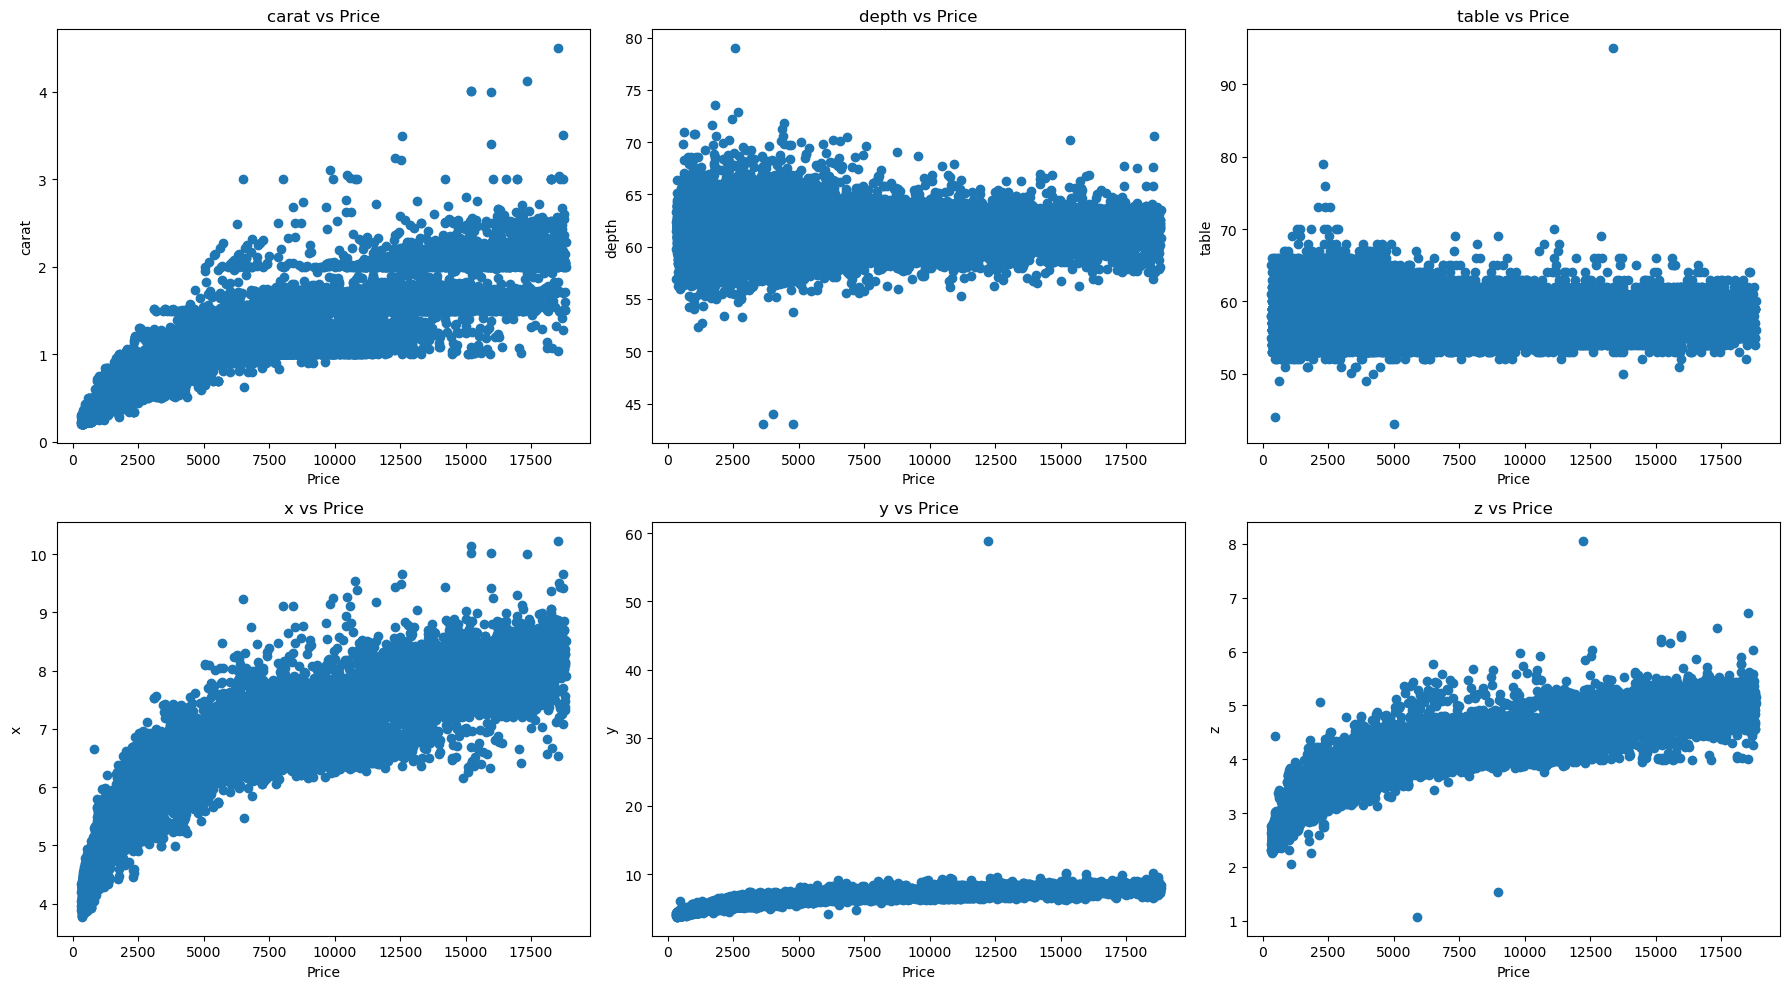

In [160]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Lets clean the dataset

In [161]:
len(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45'))

8

In [162]:
diamonds_train.drop(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45').index, inplace=True)

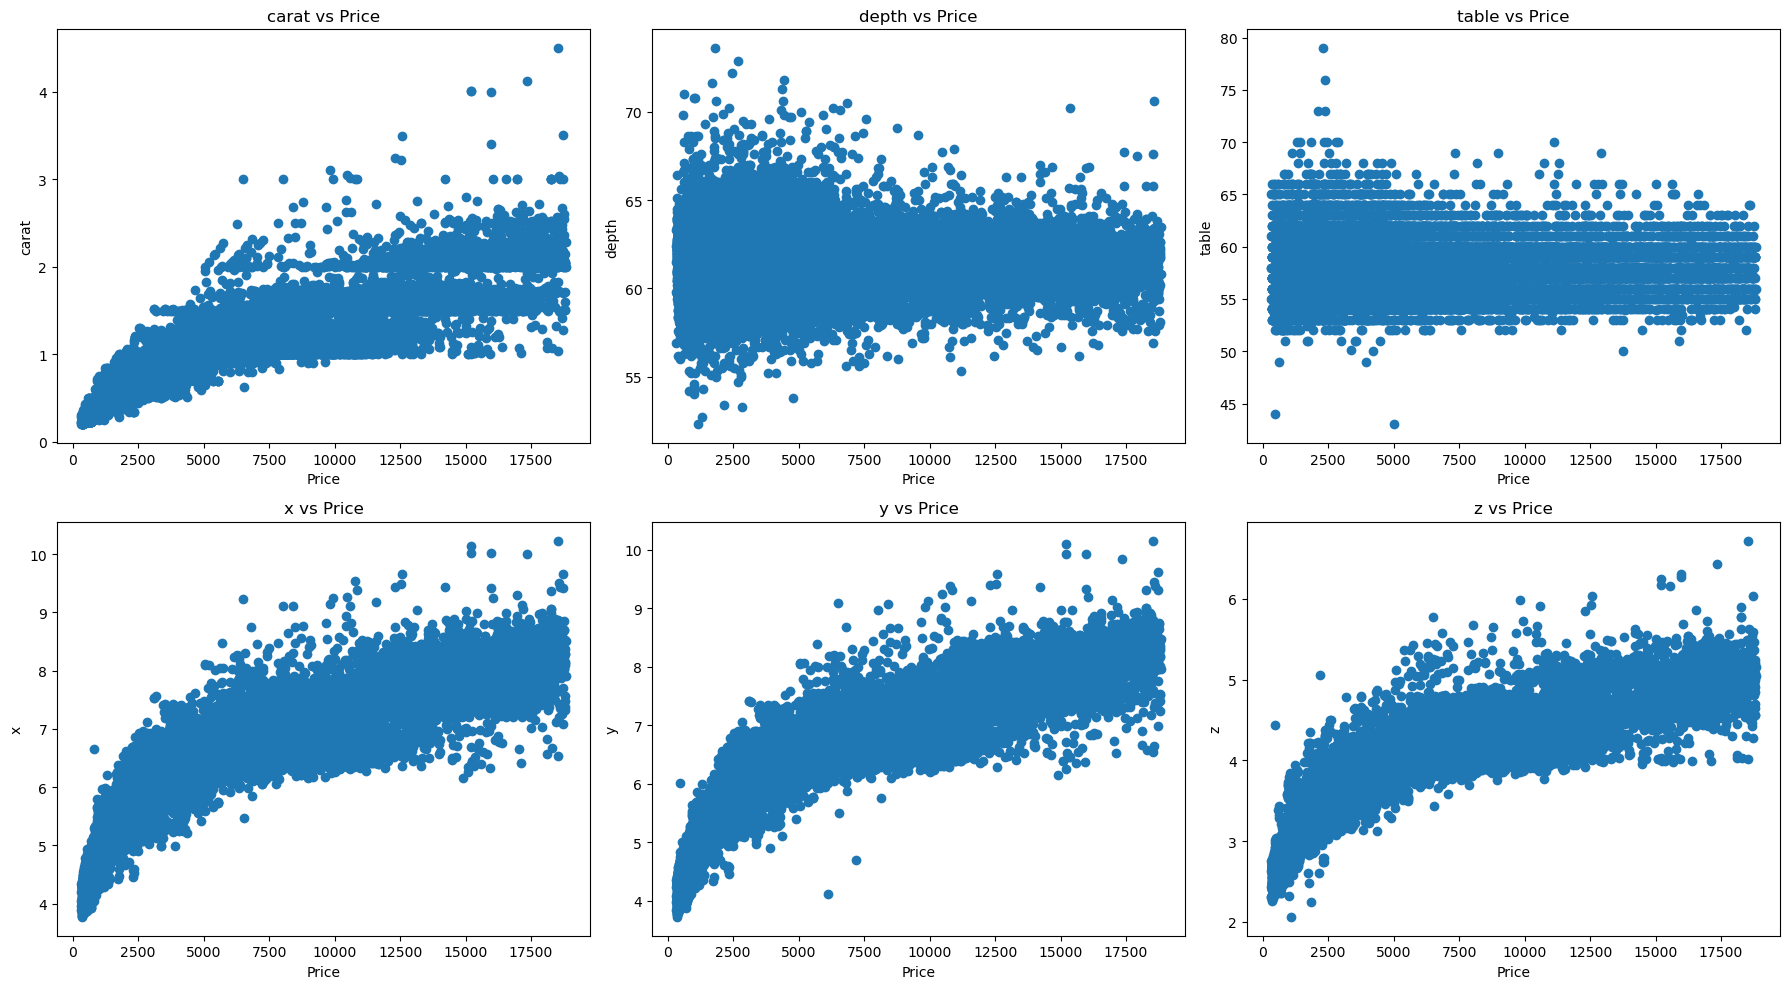

In [163]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

The dataset seems cleaner now

## Features Engineering

Knowing that the diamonds price is mainly defined by Rapaport Diamonds Report, we will reproduce this clasification with dataset features. For this, first we need to create bins for carat and then combine them with color and clarity.

### - Carat binning

In [164]:
# Logaritmic binning:

diamonds_train['log_carat'] = np.log(diamonds_train['carat'])

# Define the bin edges
bins = np.linspace(diamonds_train['log_carat'].min(), diamonds_train['log_carat'].max(), 10)

# Bin the data based on log values
diamonds_train['carat_bin'] = pd.cut(diamonds_train['log_carat'], bins=bins, labels=False)

diamonds_train.head(10)

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,0.190620,5.0
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,-1.139434,1.0
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,-0.342490,3.0
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,-0.891598,2.0
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,0.019803,4.0
5,9057,1.52,Tel Aviv,61.2,57.0,7.45,7.39,4.54,Ideal,F,SI2,0.418710,5.0
6,3733,1.01,Amsterdam,65.2,56.0,6.23,6.19,4.05,Fair,H,VS2,0.009950,4.0
7,8608,1.52,Kimberly,62.3,58.0,7.32,7.35,4.57,Ideal,J,VS1,0.418710,5.0
8,557,0.31,Zurich,61.8,54.2,4.33,4.37,2.69,Ideal,H,VS1,-1.171183,1.0
9,6741,1.14,Antwerp,61.7,56.0,6.71,6.75,4.15,Ideal,G,SI1,0.131028,5.0


In [165]:
diamonds_train['carat_bin'].unique()

array([ 5.,  1.,  3.,  2.,  4.,  6.,  7.,  0., nan,  8.])

In [166]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40454
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      40431 non-null  int64  
 1   carat      40431 non-null  float64
 2   city       40431 non-null  object 
 3   depth      40431 non-null  float64
 4   table      40431 non-null  float64
 5   x          40431 non-null  float64
 6   y          40431 non-null  float64
 7   z          40431 non-null  float64
 8   cut        40431 non-null  object 
 9   color      40431 non-null  object 
 10  clarity    40431 non-null  object 
 11  log_carat  40431 non-null  float64
 12  carat_bin  40425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 4.3+ MB


In [167]:
missing_values = diamonds_train['carat_bin'].isna()

In [168]:
diamonds_train[missing_values == True]

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin
1582,345,0.2,Antwerp,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,-1.609438,NaN
5157,367,0.2,Surat,61.7,60.0,3.77,3.72,2.31,Premium,D,VS2,-1.609438,NaN
6423,367,0.2,Luxembourg,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,-1.609438,NaN
6550,367,0.2,Surat,59.7,62.0,3.84,3.80,2.28,Premium,E,VS2,-1.609438,NaN
16597,367,0.2,Kimberly,59.7,55.0,3.86,3.84,2.30,Ideal,E,VS2,-1.609438,NaN
23007,367,0.2,Kimberly,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,-1.609438,NaN


Logaritmic binning provides just a few bins and also generates some nulls.

In [169]:
# K-means clustering:

kmeans = KMeans(n_clusters=10, random_state=42)
diamonds_train['carat_bin2'] = kmeans.fit_predict(diamonds_train[['carat']])

diamonds_train.head(10)

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin,carat_bin2
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,0.190620,5.0,7
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,-1.139434,1.0,5
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,-0.342490,3.0,4
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,-0.891598,2.0,1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,0.019803,4.0,9
5,9057,1.52,Tel Aviv,61.2,57.0,7.45,7.39,4.54,Ideal,F,SI2,0.418710,5.0,3
6,3733,1.01,Amsterdam,65.2,56.0,6.23,6.19,4.05,Fair,H,VS2,0.009950,4.0,9
7,8608,1.52,Kimberly,62.3,58.0,7.32,7.35,4.57,Ideal,J,VS1,0.418710,5.0,3
8,557,0.31,Zurich,61.8,54.2,4.33,4.37,2.69,Ideal,H,VS1,-1.171183,1.0,5
9,6741,1.14,Antwerp,61.7,56.0,6.71,6.75,4.15,Ideal,G,SI1,0.131028,5.0,0


In [170]:
# Get the cluster centers (mean carat value for each cluster)
cluster_centers = kmeans.cluster_centers_

# Sort the cluster centers to understand the carat ranges
sorted_centers = np.sort(cluster_centers.flatten())

# Display carat ranges corresponding to each cluster
print("Sorted cluster centers (mean carat values for each cluster):", sorted_centers)

# Create bins based on sorted cluster centers (optional)
bins = sorted_centers

Sorted cluster centers (mean carat values for each cluster): [0.30845416 0.40338621 0.53861755 0.73114882 0.97544717 1.09036488
 1.24602867 1.56188691 2.06249185 2.6159893 ]


This approach seems more reasonable, given that Rapaport report usually has 10 carat bins.

### - Combination of metrics

In [171]:
# carat + cat + clarity

diamonds_train['3C'] = diamonds_train['carat_bin2'].astype('str') + diamonds_train['color'] + diamonds_train['clarity']

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin,carat_bin2,3C
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,0.190620,5.0,7,7JVS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,-1.139434,1.0,5,5HVS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,-0.342490,3.0,4,4GVS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,-0.891598,2.0,1,1DSI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,0.019803,4.0,9,9GSI1


In [172]:
# Define a function to apply target encoding with regularization on each row

def target_encoding(row, global_mean_price, combination_mean_price, combination_count):

    comb_key = row['3C']
    
    mean_price = combination_mean_price.get(comb_key, global_mean_price)  # Use global mean if combination not found
    count = combination_count.get(comb_key, 0)
    
    alpha = 10  # Regularization factor
    encoded_value = (count * mean_price + alpha * global_mean_price) / (count + alpha)
    
    return encoded_value

In [174]:
# Step 1: Calculate the global mean price (mean of the target)
global_mean_price = diamonds_train['price'].mean()

# Step 2: Calculate the mean price for each combination of carat_bin, color, and clarity
combination_mean_price = diamonds_train.groupby('3C')['price'].mean()

# Step 3: Calculate the count of each combination for regularization
combination_count = diamonds_train.groupby('3C')['price'].count()

# Step 6: Apply the target encoding function to each row
diamonds_train['3C_encoded'] = diamonds_train.apply(lambda row: target_encoding(
                                                                row, 
                                                                global_mean_price,
                                                                combination_mean_price,
                                                                combination_count), axis=1)

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin,carat_bin2,3C,3C_encoded
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,0.190620,5.0,7,7JVS2,5146.033968
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,-1.139434,1.0,5,5HVS2,689.483782
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,-0.342490,3.0,4,4GVS1,3031.511092
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,-0.891598,2.0,1,1DSI1,983.199985
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,0.019803,4.0,9,9GSI1,4376.333525


In [175]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40454
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       40431 non-null  int64  
 1   carat       40431 non-null  float64
 2   city        40431 non-null  object 
 3   depth       40431 non-null  float64
 4   table       40431 non-null  float64
 5   x           40431 non-null  float64
 6   y           40431 non-null  float64
 7   z           40431 non-null  float64
 8   cut         40431 non-null  object 
 9   color       40431 non-null  object 
 10  clarity     40431 non-null  object 
 11  log_carat   40431 non-null  float64
 12  carat_bin   40425 non-null  float64
 13  carat_bin2  40431 non-null  int32  
 14  3C          40431 non-null  object 
 15  3C_encoded  40431 non-null  float64
dtypes: float64(9), int32(1), int64(1), object(5)
memory usage: 5.1+ MB


In [176]:
# Cut as Price Multiplier:

diamonds_train['cut'].value_counts()


cut
Ideal        16215
Premium      10250
Very Good     9095
Good          3659
Fair          1212
Name: count, dtype: int64

In [177]:
price_mult = {'Fair':1, 'Good':1.1, 'Very Good':1.2, 'Premium':1.3, 'Ideal':1.4}
diamonds_train['cut'] = diamonds_train['cut'].map(price_mult)

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,log_carat,carat_bin,carat_bin2,3C,3C_encoded
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,1.3,J,VS2,0.190620,5.0,7,7JVS2,5146.033968
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,1.2,H,VS2,-1.139434,1.0,5,5HVS2,689.483782
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,1.0,G,VS1,-0.342490,3.0,4,4GVS1,3031.511092
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,1.1,D,SI1,-0.891598,2.0,1,1DSI1,983.199985
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,1.4,G,SI1,0.019803,4.0,9,9GSI1,4376.333525


In [178]:
baseline_train = diamonds_train.drop(['city', 'color', 'clarity', 'log_carat', 'carat_bin', '3C'], axis = 1)

baseline_train.head()

,price,carat,depth,table,x,y,z,cut,carat_bin2,3C_encoded
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,1.3,7,5146.033968
1,505,0.32,63.0,57.0,4.35,4.38,2.75,1.2,5,689.483782
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,1.0,4,3031.511092
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1.1,1,983.199985
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,1.4,9,4376.333525


### Correlation

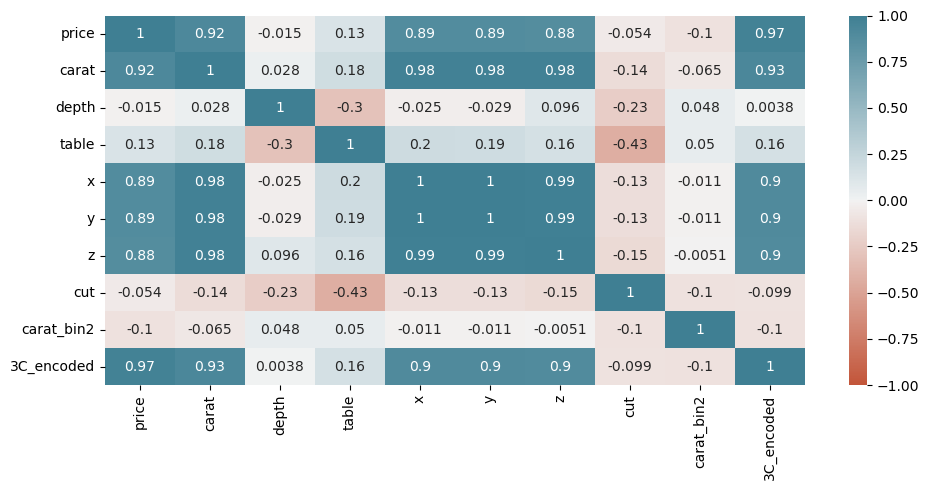

In [179]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(baseline_train.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax,
                 annot=True)
plt.tight_layout()

There are several metrics with high relationship. Lets keep them all at the moment.

### Save pre-processing to csv

In [180]:
#baseline_train.to_csv('../data/baseline_train.csv', index=False)

## 3. Model selection

In [181]:
y0 = baseline_train['price'].astype('float64').to_numpy()
X0 = baseline_train[[col for col in baseline_train.columns if col != 'price']].to_numpy()

In [182]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. a) ElasticNet

In [13]:
model_elasticnet = ElasticNet()

fn.cross_val(model_elasticnet, X, y)

Cross val. scores: [-1833.64390701 -1937.89311616 -1838.94606472 -1834.4722746
 -1803.07991273] 

Mean of scores: 1849.6070550429442 



## 3. b) SVR

In [16]:
model_svr = SVR()

fn.cross_val(model_svr, X, y)

Cross val. scores: [-4208.27630307 -4349.59084525 -4258.49970513 -4225.98461454
 -4222.88255361] 

Mean of scores: 4253.046804323332 



## 3. c) Ridge

In [17]:
model_ridge = Ridge()

fn.cross_val(model_ridge, X, y)

Cross val. scores: [-1162.37097317 -1236.84771998 -1181.36659532 -1123.77678443
 -1086.81019334] 

Mean of scores: 1158.2344532457496 



## 3. d) Decision Tree Regressor

In [20]:
model_decisiontree = DecisionTreeRegressor()

fn.cross_val(model_decisiontree, X, y)

Cross val. scores: [-877.62931559 -872.70115246 -907.36536323 -858.23774212 -845.13098535] 

Mean of scores: 872.2129117503431 



## 3. e) RandomForestRegressor

In [48]:
model_randomforest = RandomForestRegressor()

fn.cross_val(model_randomforest, X, y)

Cross val. scores: [-654.95224026 -662.57559913 -670.01148258 -665.67893135 -651.56808185] 

Mean of scores: 660.9572670347252 



## 3. f) GradientBoostingRegressor

In [23]:
model_gradientboosting = GradientBoostingRegressor()

fn.cross_val(model_gradientboosting, X, y)

Cross val. scores: [-879.59064277 -856.04185565 -889.98164808 -869.74512933 -827.06412632] 

Mean of scores: 864.484680430803 



## 3. g) ExtraTreesRegressor

In [26]:
model_extratrees = ExtraTreesRegressor()

fn.cross_val(model_extratrees, X, y)

Cross val. scores: [-613.81259552 -619.0077115  -614.08969898 -620.04012503 -598.93489935] 

Mean of scores: 613.1770060765838 



## 3. h) BaggingRegressor

In [28]:
model_bagging = BaggingRegressor()

fn.cross_val(model_bagging, X, y)

Cross val. scores: [-691.21925102 -708.19306603 -713.79584737 -700.17574779 -678.97964718] 

Mean of scores: 698.4727118796867 



## 3. i) StackingRegressor

In [183]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X0)

In [184]:
scaled_data_train.shape

(40431, 9)

In [185]:
X1_train, X1_test, y1_train, y1_test = train_test_split(scaled_data_train, y0, test_size = 0.2, random_state = 42)

In [186]:
# Define base models
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=200, 
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features=None)),
    ('lr', ExtraTreesRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=6,
                                min_samples_leaf=2,
                                max_features=None))
]

# Define meta-model (Ridge regression)
meta_model = Ridge()


#    ('gb', GradientBoostingRegressor(n_estimators=100)),

In [187]:
# Create the Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

In [188]:
fn.cross_val(stacking_regressor, scaled_data_train, y0)

Cross val. scores: [-569.86749141 -578.06767273 -587.96245333 -593.64387633 -586.65077975] 

Mean of scores: 583.2384547091931 



## 3. j) AdaBoostRegressor

In [31]:
model_adaboost = AdaBoostRegressor()

fn.cross_val(model_adaboost, X, y)

Cross val. scores: [-1599.44833947 -1511.38562057 -1520.56161739 -1555.29603015
 -1547.01533228] 

Mean of scores: 1546.7413879698531 



**CONCLUSION**: Stacking Regressor provides the best metrics: RMSE 606 in test dataset and 603 in Kaggle.

### Grid Search: RandomForestRegressor

In [45]:
param_grid = {'n_estimators': [100, 200, 300],  # Number of trees in the forest.
              'max_depth': [None, 3, 10],  # Maximum depth of the trees.
              'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split.
              }

In [49]:
grid_search = GridSearchCV(model_randomforest,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [50]:
grid_search.fit(X, y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 

Best score:  659.2117645213639 



### Grid Search: ExtraTreesRegressor

In [62]:
param_grid = {'n_estimators': [100],  # Number of trees in the forest.
              'max_depth': [None],  # Maximum depth of the trees.
              'min_samples_split': [6],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None]  # Number of features to consider when looking for the best split.
              }

In [63]:
grid_search = GridSearchCV(model_extratrees,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [64]:
grid_search.fit(X, y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best hyperparameters:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100} 

Best score:  606.4497365477694 



### Fit Model

In [ ]:
stacking_regressor.fit(X1_train, y1_train)
y1_pred = stacking_regressor.predict(X1_test)

### Visual check

In [ ]:
check = pd.DataFrame({'Ground truth': y1_test, 'Predictions': y1_pred, 'Diff': y1_test - y1_pred})
check

In [ ]:
check.reset_index(inplace=True)

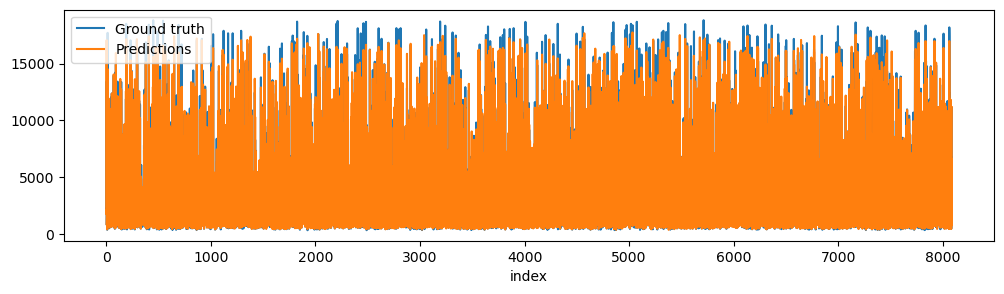

In [192]:
check.plot(x='index', y=['Ground truth', 'Predictions'], kind='line', figsize=(12, 3));

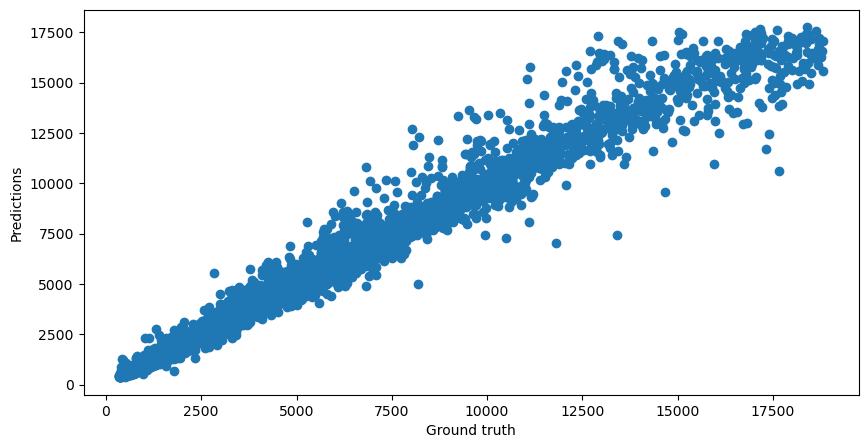

In [193]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.scatter(y1_test, y1_pred)
ax.set_xlabel('Ground truth')
ax.set_ylabel('Predictions')
#ax.set_title('')
plt.show()

# 4. Predictions

### Upload diamonds test data from csv

In [194]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
#diamonds_test.head()

### Transformations

In [195]:
# K-means clustering:

kmeans2 = KMeans(n_clusters=10, random_state=42)
diamonds_test['carat_bin2'] = kmeans2.fit_predict(diamonds_test[['carat']])

In [196]:
# carat + cat + clarity

diamonds_test['3C'] = diamonds_test['carat_bin2'].astype('str') + diamonds_test['color'] + diamonds_test['clarity']

In [197]:
# Target encoding for the new metric

diamonds_test['3C_encoded'] = diamonds_test.apply(lambda row: target_encoding(row,
                                                                              global_mean_price,
                                                                              combination_mean_price,
                                                                              combination_count), axis=1)

In [198]:
# Ordinal encoding for cut

price_mult2 = {'Fair':1, 'Good':1.1, 'Very Good':1.2, 'Premium':1.3, 'Ideal':1.4}
diamonds_test['cut'] = diamonds_test['cut'].map(price_mult2)

In [199]:
baseline_test = diamonds_test.drop(['id', 'city', 'color', 'clarity', '3C'], axis = 1)

baseline_train.head()

,price,carat,depth,table,x,y,z,cut,carat_bin2,3C_encoded
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,1.3,7,5146.033968
1,505,0.32,63.0,57.0,4.35,4.38,2.75,1.2,5,689.483782
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,1.0,4,3031.511092
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1.1,1,983.199985
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,1.4,9,4376.333525


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['carat'], density=True, bins=15)
baseline_train['carat'].plot.density(ax=axes[0])
axes[0].set_title('Train carat distribution')

axes[1].hist(baseline_test['carat'], density=True, bins=15)
baseline_test['carat'].plot.density(ax=axes[1])
axes[1].set_title('Test carat distribution')

plt.show()

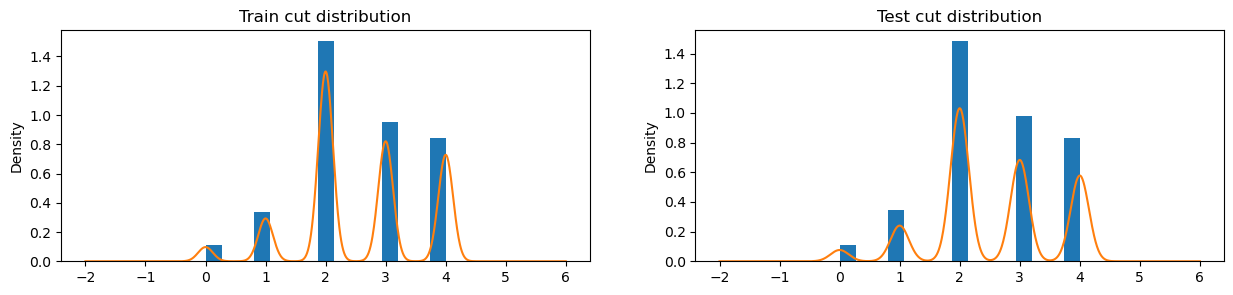

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['cut'], density=True, bins=15)
baseline_train['cut'].plot.density(ax=axes[0])
axes[0].set_title('Train cut distribution')

axes[1].hist(baseline_test['cut'], density=True, bins=15)
baseline_test['cut'].plot.density(ax=axes[1])
axes[1].set_title('Test cut distribution')

plt.show()

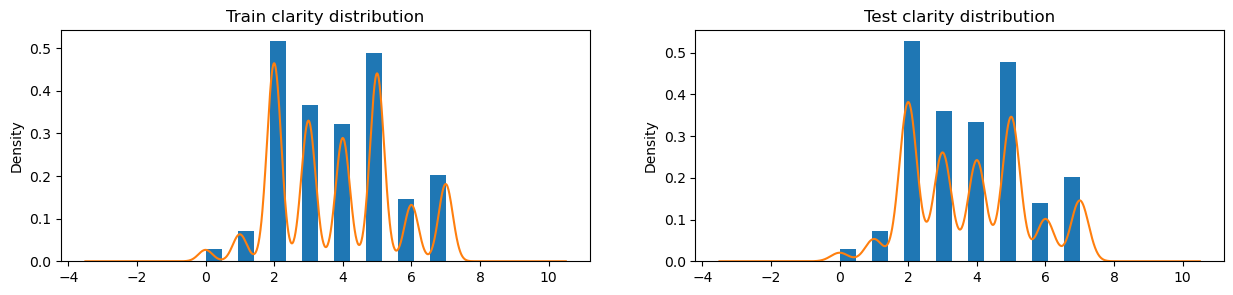

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['clarity'], density=True, bins=15)
baseline_train['clarity'].plot.density(ax=axes[0])
axes[0].set_title('Train clarity distribution')

axes[1].hist(baseline_test['clarity'], density=True, bins=15)
baseline_test['clarity'].plot.density(ax=axes[1])
axes[1].set_title('Test clarity distribution')

plt.show()

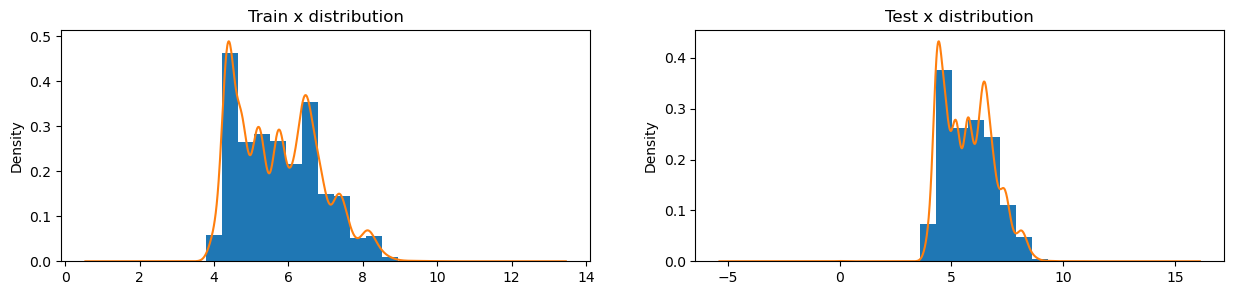

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

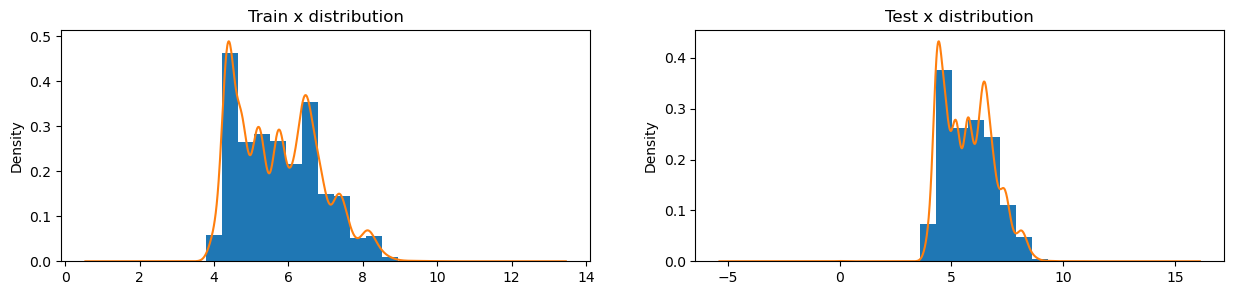

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

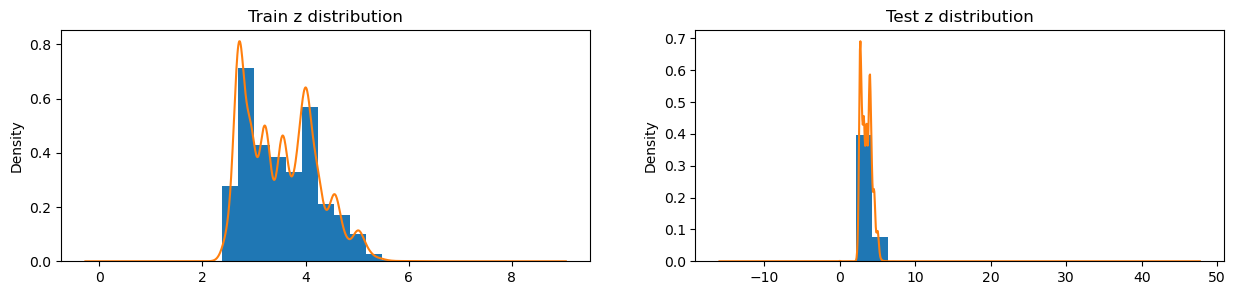

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['z'], density=True, bins=15)
baseline_train['z'].plot.density(ax=axes[0])
axes[0].set_title('Train z distribution')

axes[1].hist(baseline_test['z'], density=True, bins=15)
baseline_test['z'].plot.density(ax=axes[1])
axes[1].set_title('Test z distribution')

plt.show()

### Scalling

In [200]:
scaler = StandardScaler()
scaled_data_test = scaler.fit_transform(baseline_test)

In [201]:
scaled_data_test

array([[-0.01841187, -0.81063246,  0.66950043, ...,  0.17309121,
        -1.03363007, -1.23611732],
       [ 0.85507765,  0.98670044, -0.51495701, ...,  0.87078717,
         0.92573082,  0.64727707],
       [ 1.64334867,  0.08803399,  0.3211306 , ...,  1.40431938,
        -1.42550224, -0.13350489],
       ...,
       [-0.21015347,  0.98670044, -0.09691321, ..., -0.01843317,
        -1.03363007, -1.18440443],
       [-0.21015347, -0.81063246, -2.04778429, ..., -0.12787567,
        -1.03363007, -1.17442866],
       [-0.84929214,  0.98670044,  0.46047853, ..., -0.82557163,
         2.10134735, -0.46207916]], shape=(13485, 9))

### Predict: StackingRegressor

In [202]:
stacking_regressor_pred = stacking_regressor.predict(scaled_data_test)

In [203]:
stacking_regressor_pred

array([1329.87032847, 6276.49418496, 3845.3387509 , ...,  855.000582  ,
       1101.39098447,  795.30644588], shape=(13485,))

### Save

In [204]:
fn.save_pred(diamonds_test, stacking_regressor_pred, 'encod03_featu06_model01')

'file saved succesfully'